In [ ]:
import numpy as np
import math
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Part I
### Forward Simulation and Logistic Regression

**FORWARD SIMULATION**

In [ ]:
alpha=0.9 # Probability parameter alpha in (0.5, 1) for P(Z|C)
beta=0.2  # Transition probability parameter for moving to and from parallel processing
gamma=0.1  # Transition probability parameter between states
lmda=(1, 5)  # Rate parameters for the Poisson distribution modeling spike counts under each attention state.

# Transition probability matrix for the HMM, parameterized by gamma and beta (Transition probabilities of switching between states C in {0, 1, 2}).
Gamma = np.array([[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta*0.5, beta*0.5, 1-beta]])
Z_prob = [[alpha, 1-alpha], [1-alpha, alpha], [0.5, 0.5]]

def forward_sim(n, T, alpha=0.9, gamma=0.1, beta=0.2, lmda=(1, 5)): 
    # Pre-defined (transition) probabilities
    Gamma = [[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta*0.5, beta*0.5, 1-beta]]
    
    # Initialize arrays
    C = np.zeros(T, dtype=int)
    Z = np.zeros((T, n), dtype=int)
    X = np.zeros((T, n), dtype=int)

    # Simulate the proces for the remaining t=1 to t=T timesteps
    for t in range(T):
        C[t] = random.choices([0, 1, 2], Gamma[2 if t == 0 else C[t-1]])[0] # First state is 0, every other picked random via the Gamma transition matrix
        for i in range(0, n):
            Z[t, i] = random.choices([0, 1], Z_prob[C[t]])[0] # Simulated hidden variables Z drawn from the distribution P(Z|C)
            X[t, i] = np.random.poisson(lam = lmda[Z[t, i]]) # Simulated observed variables drawn at random from the poisson distribution.

    return C, Z, X

In [ ]:
### Simulate Data for T timesteps and n neurons ###
T = 100  # Time period
n = 10   # Number of neurons

# the C_0 vector which would correspond to C[-1], but is redundant for the purposes of the C array, 
# which corresponds to a C for every T. In reality we have T+1 C variables and T x N Z and X variables.
C_initial = np.array([0, 0, 1]) 
C, Z, X = forward_sim(n, T) # Simulated arrays for C, Z, X


**VISUALIZATION**

In [ ]:

#mean Z pr tid
avg_Z = np.mean(Z,axis=1).reshape(1,-1)[0]
avg_X = np.mean(X,axis=1).reshape(1,-1)[0]

# Visualize the data
plt.figure(figsize=(16, 8))

# Plot hidden states (C)
plt.subplot(3, 1, 1)
plt.plot(range(T), C, marker='o', color='blue')
plt.title('Hidden States (C)')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.grid(True)

# Plot observed states (Z)
plt.subplot(3, 1, 2)
for i in range(n):
    plt.plot(range(T), Z[:, i], marker='o', alpha=1.5/n, color = 'red', linewidth = 0)
plt.plot(range(T), avg_Z, color='green', label = 'Mean State')
plt.title('Hidden States (Z)')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.legend()
plt.grid(True)

# Plot observed states (X)
plt.subplot(3, 1, 3)
plt.plot(range(T), avg_X, color='red', label = 'Mean Spike Count')
plt.title('Mean Observed (X)')
plt.xlabel('Time Step')
plt.ylabel('Spike Count')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### MULTICLASS LOGISTIC REGRESSION 

In [ ]:
# Split the date for validation
X_train, X_test, C_train, C_test = train_test_split(X, C, test_size=0.2, random_state=42)

# Assert shapes
assert(X_train.shape == (T-0.2*T, n))
assert(X_test.shape == (0.2*T, n))
assert(C_train.shape == (T-0.2*T, ))
assert(C_test.shape == (0.2*T, ))

In [ ]:
# Train multinomial logistic regression using Scikit-Learn
LogReg = LogisticRegression(random_state=42, multi_class='multinomial')

LogReg.fit(X_train, C_train)
LogReg.score(X_test, C_test)

In [ ]:
# Predict_proba essentially returns the CPD for P(C|X)
LogReg.predict_proba(X)

# Part II
### Inference algorithms, Testing Inference on Simulated Data

**INFERENCE OF Z**

In [ ]:
def PX_given_Z(x, z, lmda=(1, 5)):
    return (np.exp(-1 * lmda[z]) * ((lmda[z]**x)/math.factorial(x)))

# Returns the answer to the query P(X=x|Z=z)

In [ ]:
#We assume that P(Z=0) = 0.5 due to the distribution of Z | C, and due to an assumption that P(C=1) = P(C=0)
def Z_marg():
    return (0.5, 0.5)

def X_marg(X):
    #We start by calculating P(X) for every observed X and save them in a table. It doesn't make sense to compute P(X) for unobserved values of X
    x_marg = np.zeros(np.max(X)+1)
    z_marg = Z_marg()
    #We calculate P(X) using the formula: P(X=x) = P(X=x|Z=0)P(Z=0) + P(X=x|Z=1)P(Z=1)
    #This works because Z ony takes values in {0,1}. We simply obtain the joint distribution P(X,Z) and sum out Z
    for i in range(len(x_marg)):
        x_marg[i] = PX_given_Z(i, 0)*z_marg[0] + PX_given_Z(i, 1)*z_marg[1]
    return x_marg

    #X_marg[i] holds the answer for the query P(X=i)
    #Likewise Z_marg[i] holds the answer for the query p(Z=i)
    

In [ ]:
def infer_Z(X):
    Z_inferred = np.zeros((X.shape[0],X.shape[1],2), dtype=float) 
    #For every observed X=x, we calculate the conditional probaility P(Z=0|X=x)
        #We use Bayes theorem to do this. 
    x_marg = X_marg(X)
    z_marg = Z_marg()
    for i in range(Z_inferred.shape[0]): 
        for j in range(Z_inferred.shape[1]): 
            Z_inferred[i,j,0] = (PX_given_Z(X[i,j], 0)*z_marg[0])/(x_marg[X[i,j]])
            Z_inferred[i,j,1] = 1 - Z_inferred[i,j,0] 
    return Z_inferred

In [ ]:
def PZ_given_C(c, z, alpha=0.9):
    Z_prob = np.array([[alpha, 1-alpha], [1-alpha, alpha], [0.5, 0.5]])
    return Z_prob[c, z]

### Forward Algorithm

In [ ]:
def calc_emission_proba(t: int, c: int, X) -> float:
    """
    Calculates the emission probabilities at timestep t
    The probabilities given by P(X_1,t...X_n,t|C_t)
    P(Z|C) by function PZ_given_C(c, z)
    P(X|Z) Poisson distribution given by PX_given_Z(x, z)
    """
    emission_proba = 0.
    for i in range(n):
        emission_proba += np.log(PZ_given_C(c, 0)*PX_given_Z(X[t, i], 0) + PZ_given_C(c, 1)*PX_given_Z(X[t, i], 1))
    emission_proba = np.exp(emission_proba)
    return emission_proba

In [ ]:
def forward(X):
    """
    Iteratively updates the Alpha_t vectors in the Alpha matrix.
    The Alpha matrix represents the P(C|X) distribution for each timestep T as an T x 3 matrix.
    """
    # Initialization of the forward probabilities matrix, Alpha.
    T = X.shape[0]
    Alpha = np.zeros((T, 3), dtype=float)  # T x 3 matrix P(C|X)

    for t in range(T):
        for c in range(3):
            c_prev = 0. # For calculating SUM_c_t-1 P(C_t|c_t-1)*Alpha_t-1(c_t-1)
            for c_ in range(3):
                c_prev += Gamma[c_, c]*(C_initial[c_] if t == 0 else Alpha[t-1, c_])
            Alpha[t, c] = calc_emission_proba(t, c, X)*c_prev # Alpha_t = P(X_1,t,...,X_n,t|C_t) * SUM_c_t-1 P(C_t|c_t-1)*Alpha_t-1(c_t-1)
        row_sum = np.sum(Alpha[t], axis=0) # Normalizing sum for each row
        Alpha[t] = Alpha[t]/row_sum # Row-wise normalization for the CPD, normalizing the unnormalized Gibbs measure of each row.
    return Alpha

**CONFIDENCE AGAINST SIMULATED DATA**

In [ ]:
def calc_confidence_of_C(infered_C, true_C):
    Confidence = np.zeros(len(true_C), dtype = float)
    for c in true_C: 
        for t in range(0, len(true_C)): 
            Confidence[t] = infered_C[t, true_C[t]]
    return np.average(Confidence)
print(calc_confidence_of_C(forward(X), C))

In [ ]:
def calc_confidence_of_Z(inferred_Z, true_Z):
    Confidence = np.zeros((true_Z.shape[0],true_Z.shape[1]), dtype = float)
    for t in range(0,true_Z.shape[0]): 
        for n in range(0, true_Z.shape[1]): 
            Confidence[t,n] = inferred_Z[t,n,[true_Z[t,n]]]
    return np.average(Confidence)


**PREDICTIONS AGAINST SIMULATED DATA**

In [ ]:
def cement_data(inferd_Z, inferd_C):
    T = inferd_Z.shape[0]
    n = inferd_Z.shape[1]
    Z = np.zeros((T,n),dtype=int)
    C = np.zeros(T,dtype=int)
    for t in range(T):
        for i in range(n):
            Z[t,i] = np.argmax(inferd_Z[t][i]) #giver det index hvor der er størst værdi i vores confidence matrix
        C[t] = np.argmax(inferd_C[t])
            
    return Z, C


In [ ]:
pred_z, pred_c = cement_data(infer_Z(X), forward(X))
print(accuracy_score(pred_z.flatten(), Z.flatten()))
print(accuracy_score(pred_c, C))


**VISUALIZING CONFIDENCE**

In [ ]:
n = 10
T = 100
C, Z, X = forward_sim(n, T)
C_conf = forward(X)
print("The average confidence of our inference of C, to the correct answer of C is " + str(calc_confidence_of_C(C_conf, C)))
plt.figure(figsize=(16, 4))
# Plot hidden states (C)
for i in range(3):  # Iterate over possible values 0, 1, 2
    plt.scatter(range(T), [i+0.05] * T,  c='red', alpha=C_conf[:, i])
plt.plot(range(T), C-0.05, marker='o', color='blue', zorder = 0)
plt.title('Hidden States (C)')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.yticks([0, 1, 2])
plt.grid(True, axis='y')  # Only grid lines on the y-axis


**MAKE PREDICTIONS ON REAL DATA**

In [ ]:
data_ = np.genfromtxt("proj_HMM/Ex_1.csv", delimiter=",", skip_header=True, dtype=int)
data = data_[:, 1:]


In [ ]:
def switch_1_and_2(arr):
    for i in range(len(arr)):
        if arr[i] == 1:
            arr[i] = 2
        elif arr[i] == 2:
            arr[i] = 1
    return arr

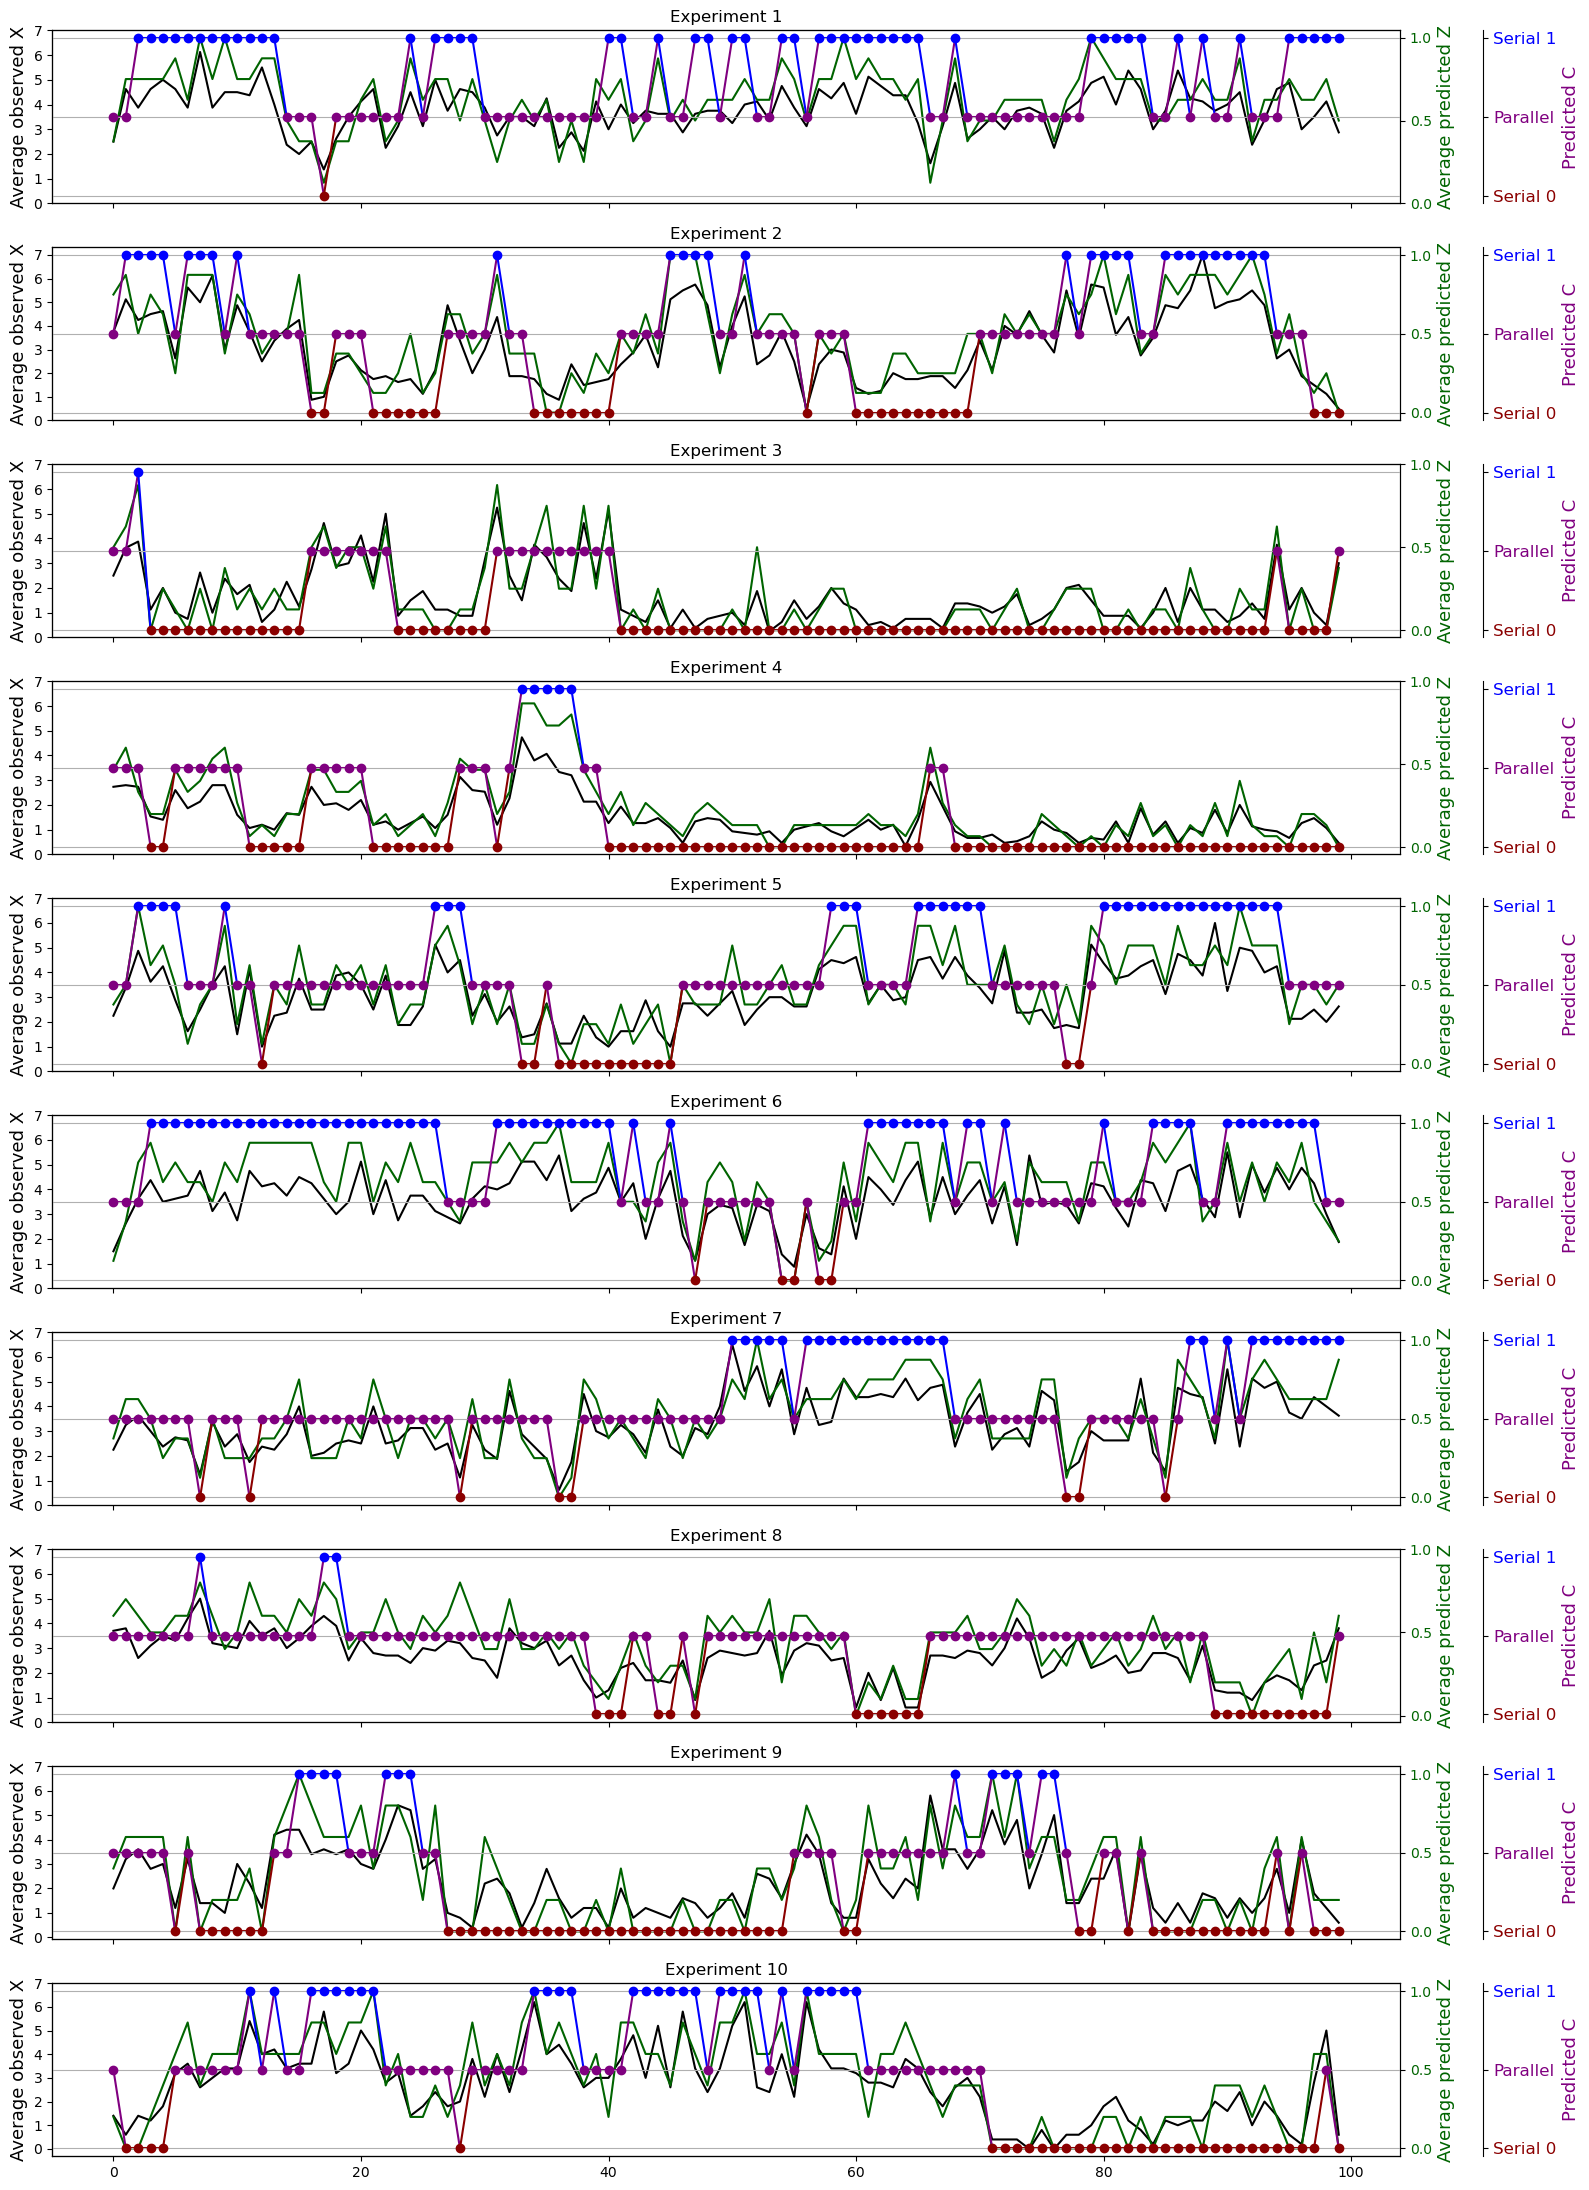

In [21]:
data_files = ["proj_HMM/Ex_1.csv", "proj_HMM/Ex_2.csv", "proj_HMM/Ex_3.csv", "proj_HMM/Ex_4.csv", "proj_HMM/Ex_5.csv", "proj_HMM/Ex_6.csv", "proj_HMM/Ex_7.csv", "proj_HMM/Ex_8.csv", "proj_HMM/Ex_9.csv", "proj_HMM/Ex_10.csv"]

# Create a figure and axis array to hold all subplots
fig, axs = plt.subplots(10, 1, figsize=(16, 22), sharex=True)

for i in range(10):
    # Load data for the current iteration
    data_ = np.genfromtxt(data_files[i % len(data_files)], delimiter=",", skip_header=True, dtype=int)
    data = data_[:, 1:]
    T = data.shape[0]  # Time period
    n = data.shape[1]   # Number of neurons

    # Assuming the rest of your plotting code remains the same
    
    Z, C = cement_data(infer_Z(data), forward(data))
    C = switch_1_and_2(C)
    avg_Z = np.mean(Z,axis=1).reshape(1,-1)[0]
    avg_X = np.mean(data,axis=1).reshape(1,-1)[0]

    ax1 = axs[i]
    ax1.plot(range(T), avg_X, color="black", zorder=3)
    ax1.set_yticks([0,1,2, 3, 4, 5, 6, 7])
    ax1.set_ylabel('Average observed X', color="black",  fontsize=13)
    ax1.tick_params(axis='y', labelcolor="black")

    ax2 = ax1.twinx()
    ax2.plot(range(T), avg_Z, color="darkgreen", zorder=2)
    ax2.set_yticks([0,0.5,1])
    ax2.set_ylabel('Average predicted Z', color="darkgreen", fontsize=13)
    ax2.tick_params(axis='y', labelcolor="darkgreen")

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Predicted C', color="purple", fontsize=13)
    for c in range(len(C)):
        if C[c] == 0:
            color = "darkred"
        elif C[c] == 1:
            color = "purple"
        else:
            color = "blue"
        ax3.plot(c, C[c], color=color, marker="o", zorder=2)

    for j in range(len(C) - 1):
        if C[j] != C[j + 1]:
            color = "black"
            if C[j] == 0:
                color = "darkred"
            elif C[j] == 1:
                color = "purple"
            else:
                color = "blue"
            ax3.plot([j, j + 1], [C[j], C[j + 1]], color=color, zorder=1)
        else: 
            if C[j] == 0:
                color = "darkred"
            elif C[j] == 1:
                color = "purple"
            else:
                color = "blue"
            ax3.plot([j, j + 1], [C[j], C[j + 1]], color=color, zorder=1)

    ax3.tick_params(axis='y', labelcolor="purple")
    ax3.set_yticks([0,1,2])
    ax3.set_yticklabels(["Serial 0", "Parallel", "Serial 1"], fontsize = 12)
    tick_labels = ax3.get_yticklabels()
    tick_labels[0].set_color('darkred')
    tick_labels[1].set_color('purple')
    tick_labels[2].set_color('blue')
    plt.title('Experiment ' + str(i+1))
    plt.grid(True)

# Adjust layout to prevent overlap of labels
plt.tight_layout()

plt.show()
